# Living Coasts Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Viewing above ground biomass datasets

This notebooks allows you to use an interactive map to extract woody above ground biomass (AGB) data generated by the European Space Agency (ESA) Climate Change Initiative (CCI) Biomass Project (https://climate.esa.int/en/projects/biomass/).  

The above ground biomass (AGB) estimates for vegetation are generally expresssed in tonnes per hectare or Mg ha^-1 and those generated from Earth observation data are largely associated with the above ground components (leaves, branches and trunks). The below ground biomass (held within the fine and coarse roots) is generally inferred (e.g., from ratios determined from ground-based measurements).   

The ESA CCI Biomass project has recently generated eight maps of AGB globally at 100 m spatial resolution (equivalent to 1 ha) for 2010 and annually from 2015 to 2021 from time-series of C-band SAR (ENVISAT Advanced Synthetic Aperture Radar (SAR) and the Japan Aerospace Exploration Agency's (JAXA) L-band SAR.   Details of the algorithm used for retrieval are given in the paper by [Santoro et al. (2024)](https://www.sciencedirect.com/science/article/pii/S2666017224000531).

## Description 

The notebook will demonstrate how you can view above ground biomass data generated from a combination of time-series of spaceborne C-band and L-band radar data.  Spatial uncertainty maps are provided with these quantifying the standard deviation of the estimate.  
The notebooks take you through the process of:

1. Identifying an area interactively using a rectangle, polygon drawn freehand or a loaded vector file, noting that the AGB datasets are currently provided for coastal Queensland in this notebook (select southeast Queensland)
2. Extracting the AGB estimate for each year (2010 and annually from 2015 to 2021) and the associated standard deviation of the AGB for the area of interest. 
3. Viewing the AGB maps for each year and associated standard deviations.
4. Viewing the land cover maps for a selected period (any time from 1988 to the present) for the same area.

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

In [2]:
%matplotlib inline

import sys
import os, re

import odc.stac
import pystac_client

import xarray as xr
import numpy as np

from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

import matplotlib.pyplot as plt
from matplotlib import colors as mcolours

from dea_tools.plotting import display_map, rgb
from dea_tools.landcover import lc_colourmap, make_colourbar, plot_land_cover

## Section 2 Select your area of interest
Here, select the geojson file for Fraser Island in Queensland which you do by using the "Load" tab in the map explorer.  You can also choose any area on Fraser Island using the 'draw' method.   Select the file 'FraserIs_box.geoson' from the uploads/AOI folder. You will then load and wait for the coordinates to appear. Once this occurs, you can go to the next cell.

In [3]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

## Section 3:  Select the time-period for the land cover maps
The maps of AGB have been generated for 2010 and annually from 2025 to 2021.  
You can observe the changes in land cover for this area from 1988 to 2020 but it suggested to use from 2010 to 2020 in the first instance.  This information can help in your interpretation of the changing amounts of AGB in each year. 

In [4]:
product='ga_ls_landcover_class_cyear_3'

# Set the range of dates for the analysis
time_range = ("2021", "2024")

# Coordinates for Area 1
central_lat = -25.1801
central_lon = 153.1887

# Sydney, New South Wales, Australia
# central_lat = -33.9
# central_lon = 151.24

buffer = 0.5
resolution=30
crs='EPSG:3577'



## Query the STAC catalogue for items relating to the query

In [5]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time_range
    )

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

lat_range = (bbox.bottom, bbox.top)
lon_range = (bbox.left, bbox.right)



Found: 16 datasets


After chosing the study area, visualise through an interactive map.  
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.


In [6]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)
display_map(x=study_area_lon, y=study_area_lat)

## Load the land cover classifications from the data cube
Here, you will load a range of environmental descriptors generated from Earth observation data (including lifeform, vegetation cover, water seasonality, water state, seasonality and persistence) and the full classifications constructed from these for each year through *Living Earth*

In [7]:
#now load the data with odc-stac
lc = odc.stac.load(
    items, #stac items
    bands=["level3", "level4"], #theses are the only two measurements
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox, #area to load over
)

Following the load step, printing the `lc` `xarray.Dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

The data are represented by the following aspects:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube, including time.
- `Data variables`: the observations loaded, with this including the environmental descriptors and full land cover classification.
- `Attributes`: additional useful information about the data, such as the `crs` (coordinate reference system)

In [8]:
lc

<xarray.Dataset> Size: 528MB
Dimensions:      (y: 4234, x: 3894, time: 4)
Coordinates:
  * y            (y) float64 34kB -2.834e+06 -2.834e+06 ... -2.961e+06
  * x            (x) float64 31kB 2.043e+06 2.043e+06 ... 2.16e+06 2.16e+06
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 32B 2021-01-01 2022-01-01 ... 2024-01-01
Data variables:
    level3       (time, y, x) float32 264MB 220.0 220.0 220.0 ... 220.0 220.0
    level4       (time, y, x) float32 264MB 103.0 101.0 101.0 ... 101.0 101.0

In [9]:
# Define a colour scheme for the Level 3
LEVEL3_COLOUR_SCHEME = {
    111: (172, 188, 45, 255, "Cultivated terrestrial vegetation"),
    112: (14, 121, 18, 255, "Natural terrestrial vegetation"),
    124: (30, 191, 121, 255, "Natural aquatic vegetation"),
    215: (218, 92, 105, 255, "Artificial surface"),
    216: (243, 171, 105, 255, "Natural bare surface"),
    220: (77, 159, 220, 255, "Water"),
    255: (255, 255, 255, 255, "No Data"),
}

In [10]:
def plot_layer(colours, data, col_wrap, size=5):
    colour_arr = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-1]) / 255)
 
    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(256) # add upper bound to make sure highest value (255) included in last colour bin
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)
    labels = {'ticks' : [111,112,124,215,216,220,255],}

    if len(data.time) == 1: 
        # Plot the provided layer
        im = data.isel(time=0).plot(
        cmap=cmap, norm=norm, add_colorbar=True, size=size, cbar_kwargs=labels
        )

    else:
        # Plot the provided layer
        im = data.plot(
        cmap=cmap, norm=norm, add_colorbar=True, col="time", col_wrap=col_wrap, size=size, cbar_kwargs=labels
        )
 
    return im

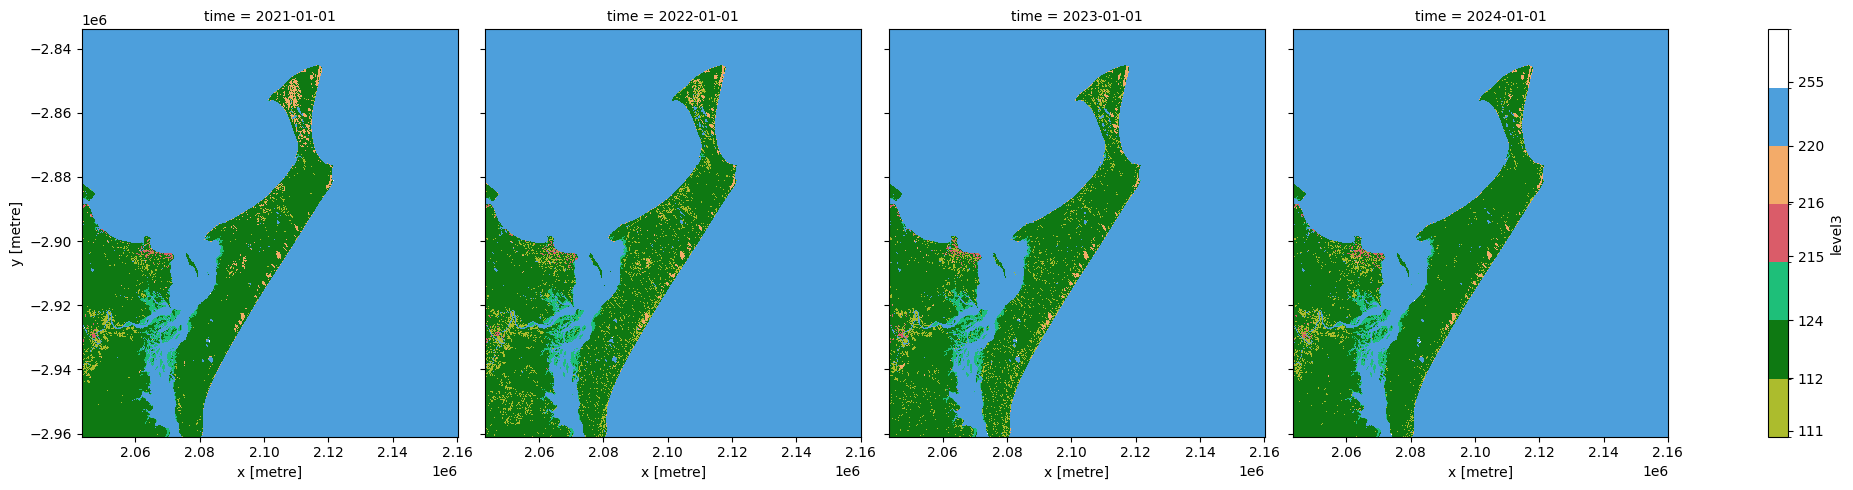

In [11]:
plot_layer(LEVEL3_COLOUR_SCHEME, lc.level3, col_wrap=4);

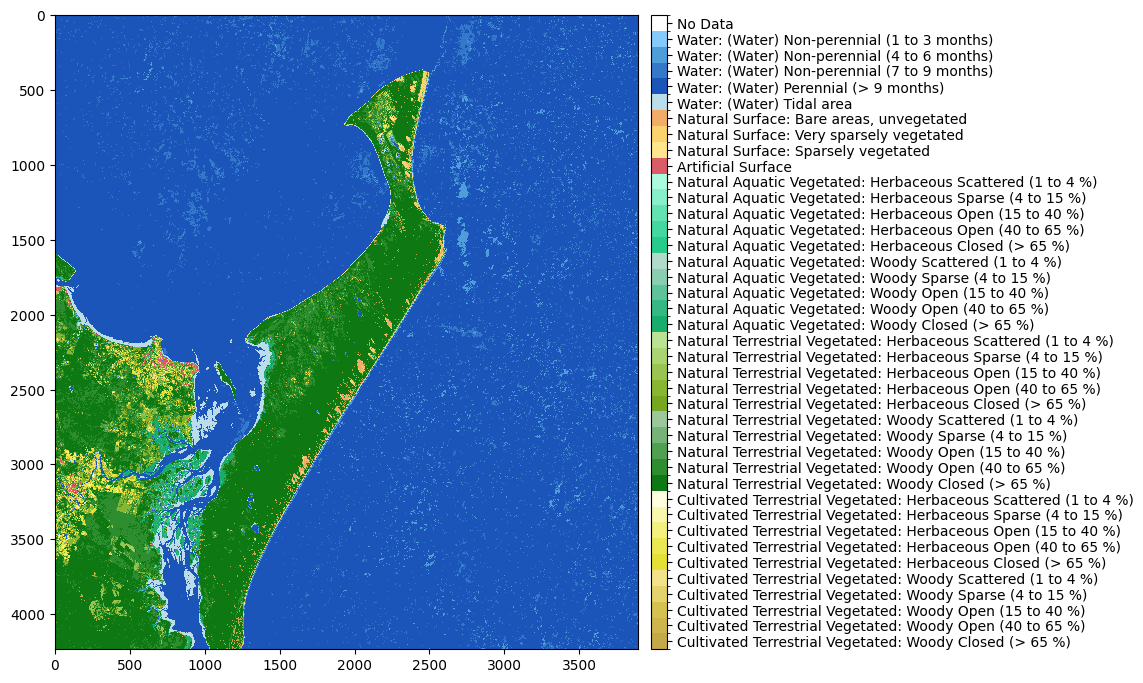

In [12]:
plot_land_cover(lc.level4, year='2024', width_pixels=600);

## Loading ESA CCI Biomass datasets (2010 and annually from 2015-2021)
The cell below allows you to select the AGB and standard deviation (SD) datasets based on the area of interest.  Here, the data for Fraser Island are associated with the 1 degree tile with latitude South 20-30 degrees and longitude 140-150 degrees (i.e., S20E150). Other datasets can be uploaded for other degree tiles (as indicated - e.g., S30E120).

In [13]:
import os
import numpy as np
import xarray as xr
import rioxarray
from pyproj import Transformer
from rasterio.transform import from_bounds
from rasterio.warp import Resampling

# --- Define folder paths and file formats ---
base_paths = {
    "S20E150": "../inputs/prac_3/S20E150_Qld_SEast/",
    "S10E140": "../inputs/prac_3/S10E140_Qld_North/",
    "S30E110": "../inputs/prac_3/S30E110_WA_SWest/",
    "S30E120": "../inputs/prac_3/S30E120_WA_SEast/"
}
file_formats = {
    "AGB": "{folder_name}_{year}_AGBcz.tif",
    "SD": "{folder_name}_{year}_SDcz.tif"
}

# --- Determine folder from lat/lon ---
def get_folder_name_from_lat_lon(lat_range, lon_range):
    folder_mapping = {
        "S20E150": (-30, -20, 150, 160),
        "S10E140": (-20, -10, 140, 150),
        "S30E110": (-40, -30, 110, 120),
        "S30E120": (-40, -30, 120, 130)
    }
    for folder_name, (lat_min, lat_max, lon_min, lon_max) in folder_mapping.items():
        if lat_range[0] >= lat_min and lat_range[1] <= lat_max and lon_range[0] >= lon_min and lon_range[1] <= lon_max:
            return folder_name
    raise ValueError("No data folder found for the provided latitude and longitude ranges.")

# --- Convert STAC bbox to geobox (in EPSG:3577) ---
def create_geobox_from_bbox(bbox, resolution=30, dst_crs="EPSG:3577"):
    """
    Convert STAC bbox (lat/lon EPSG:4326) to projected geobox raster in meters
    """
    src_crs = bbox.crs if hasattr(bbox, 'crs') else "EPSG:4326"
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

    left, bottom = transformer.transform(bbox.left, bbox.bottom)
    right, top = transformer.transform(bbox.right, bbox.top)

    if right <= left or top <= bottom:
        raise ValueError(f"Invalid projected bbox: left={left}, right={right}, bottom={bottom}, top={top}")

    width = max(1, int(np.ceil((right - left) / resolution)))
    height = max(1, int(np.ceil((top - bottom) / resolution)))

    transform = from_bounds(left, bottom, right, top, width, height)

    geobox = xr.DataArray(
        np.zeros((height, width), dtype=np.float32),
        dims=("y", "x"),
        coords={
            "y": np.linspace(top - resolution/2, bottom + resolution/2, height),
            "x": np.linspace(left + resolution/2, right - resolution/2, width)
        }
    )
    geobox.rio.write_crs(dst_crs, inplace=True)
    geobox.rio.write_transform(transform, inplace=True)
    return geobox

# --- Read and reproject raster to EPSG:3577 ---
def rio_slurp_xarray(file_path, geobox=None, resampling=Resampling.nearest):
    try:
        da = rioxarray.open_rasterio(file_path, chunks="auto")

        # Force source CRS if missing (EPSG:4326 WGS84)
        if da.rio.crs is None:
            da = da.rio.write_crs("EPSG:4326", inplace=True)

        if geobox is not None:
            # Reproject to EPSG:3577 grid on the fly
            da = da.rio.reproject(
                dst_crs=geobox.rio.crs,
                shape=geobox.shape,
                resampling=resampling,
                transform=geobox.rio.transform(),
                nodata=da.rio.nodata
            )
        return da
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return xr.DataArray()

# --- Mask invalid data ---
def mask_invalid_data(data):
    return data.where(~np.isnan(data))

# --- Process AGB and SD for given folder and years (convert to EPSG:3577 in memory) ---
def process_data_for_folder(folder_name, years, geobox):
    base_path = base_paths[folder_name]
    AGB_prj_all = {}
    SD_prj_all = {}

    for year in years:
        agb_file = os.path.join(base_path, file_formats["AGB"].format(folder_name=folder_name, year=year))
        sd_file = os.path.join(base_path, file_formats["SD"].format(folder_name=folder_name, year=year))

        if os.path.exists(agb_file):
            AGB_prj_all[year] = mask_invalid_data(rio_slurp_xarray(agb_file, geobox))
            AGB_prj_all[year] = AGB_prj_all[year].where(AGB_prj_all[year] != 0)
        else:
            print(f"Warning: AGB file for {folder_name}, year {year} not found.")
            AGB_prj_all[year] = xr.DataArray(np.zeros(geobox.shape), dims=geobox.dims, coords=geobox.coords)

        if os.path.exists(sd_file):
            SD_prj_all[year] = mask_invalid_data(rio_slurp_xarray(sd_file, geobox))
        else:
            print(f"Warning: SD file for {folder_name}, year {year} not found.")
            SD_prj_all[year] = xr.DataArray(np.zeros(AGB_prj_all[year].shape), dims=AGB_prj_all[year].dims, coords=AGB_prj_all[year].coords)

    # Combine into Datasets
    AGB = xr.Dataset({f"AGB{year}": AGB_prj_all[year] for year in years})
    SD = xr.Dataset({f"SD{year}": SD_prj_all[year] for year in years})

    # Calculate differences
    diff_biomass = xr.Dataset({
        f"d{years[i]}_{years[i+1]}": (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)).where(
            (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)) != 0
        ) for i in range(len(years)-1)
    })

    min_biomass = xr.Dataset({f"AGB{year}_Min": AGB[f"AGB{year}"] - SD[f"SD{year}"] for year in years})
    max_biomass = xr.Dataset({f"AGB{year}_Max": AGB[f"AGB{year}"] + SD[f"SD{year}"] for year in years})

    agb_sc_dec = xr.Dataset({
        f"cond_dec_{years[i]}_{years[i+1]}": (min_biomass[f"AGB{years[i]}_Min"].fillna(0) > max_biomass[f"AGB{years[i+1]}_Max"].fillna(0))
        for i in range(len(years)-1)
    })
    agb_sc_inc = xr.Dataset({
        f"cond_inc_{years[i]}_{years[i+1]}": (max_biomass[f"AGB{years[i]}_Max"].fillna(0) < min_biomass[f"AGB{years[i+1]}_Min"].fillna(0))
        for i in range(len(years)-1)
    })
    agb_sc = xr.merge([agb_sc_dec, agb_sc_inc])

    return AGB_prj_all, SD_prj_all, {folder_name: diff_biomass}, {folder_name: min_biomass}, {folder_name: max_biomass}, {folder_name: agb_sc}

# --- Usage Example ---
# STAC bbox info
lat_range = (bbox.bottom, bbox.top)
lon_range = (bbox.left, bbox.right)
folder_name = get_folder_name_from_lat_lon(lat_range, lon_range)
print(f"Selected folder: {folder_name}")

# Convert STAC bbox to geobox (EPSG:3577, resolution 30m)
geobox = create_geobox_from_bbox(bbox, resolution=30)

# Years to process
years = [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

AGB_prj_all, SD_prj_all, diff_biomass_all, min_biomass_all, max_biomass_all, agb_sc_all = process_data_for_folder(folder_name, years, geobox)

# Combine into xarray Datasets (already in EPSG:3577)
AGB = xr.Dataset({f"AGB{year}": AGB_prj_all[year] for year in years})
SD = xr.Dataset({f"SD{year}": SD_prj_all[year] for year in years})
diff_biomass = diff_biomass_all[folder_name]

Selected folder: S20E150


### View the contents of the file
Type either AGB (Above ground biomass) or AGB_SD (Standard deviation of the AGB) directly into the cell below.  Note that this is an images with eight variables (either AGB or SD) for each of the years.

In [14]:
AGB

<xarray.Dataset> Size: 64B
Dimensions:      (x: 1, y: 1, band: 1)
Coordinates:
  * x            (x) float64 8B 167.7
  * y            (y) float64 8B -39.68
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    AGB2010      (band, y, x) float32 4B 6.554e+04
    AGB2015      (band, y, x) float32 4B 6.554e+04
    AGB2016      (band, y, x) float32 4B 6.554e+04
    AGB2017      (band, y, x) float32 4B 6.554e+04
    AGB2018      (band, y, x) float32 4B 6.554e+04
    AGB2019      (band, y, x) float32 4B 6.554e+04
    AGB2020      (band, y, x) float32 4B 6.554e+04
    AGB2021      (band, y, x) float32 4B 6.554e+04

## Section 6:  View datasets

In [15]:

from matplotlib import colors 

# Define boundaries
bounds = np.array([10, 10, 40, 40])

# Create BoundaryNorm
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)

# Test the norm
print(norm([10, 40]))

bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))
#norm = mpl.colors.Normalize(vmin=2, vmax=200)
#norm(0)

[49 100]
[49 100]


TypeError: No numeric data to plot.

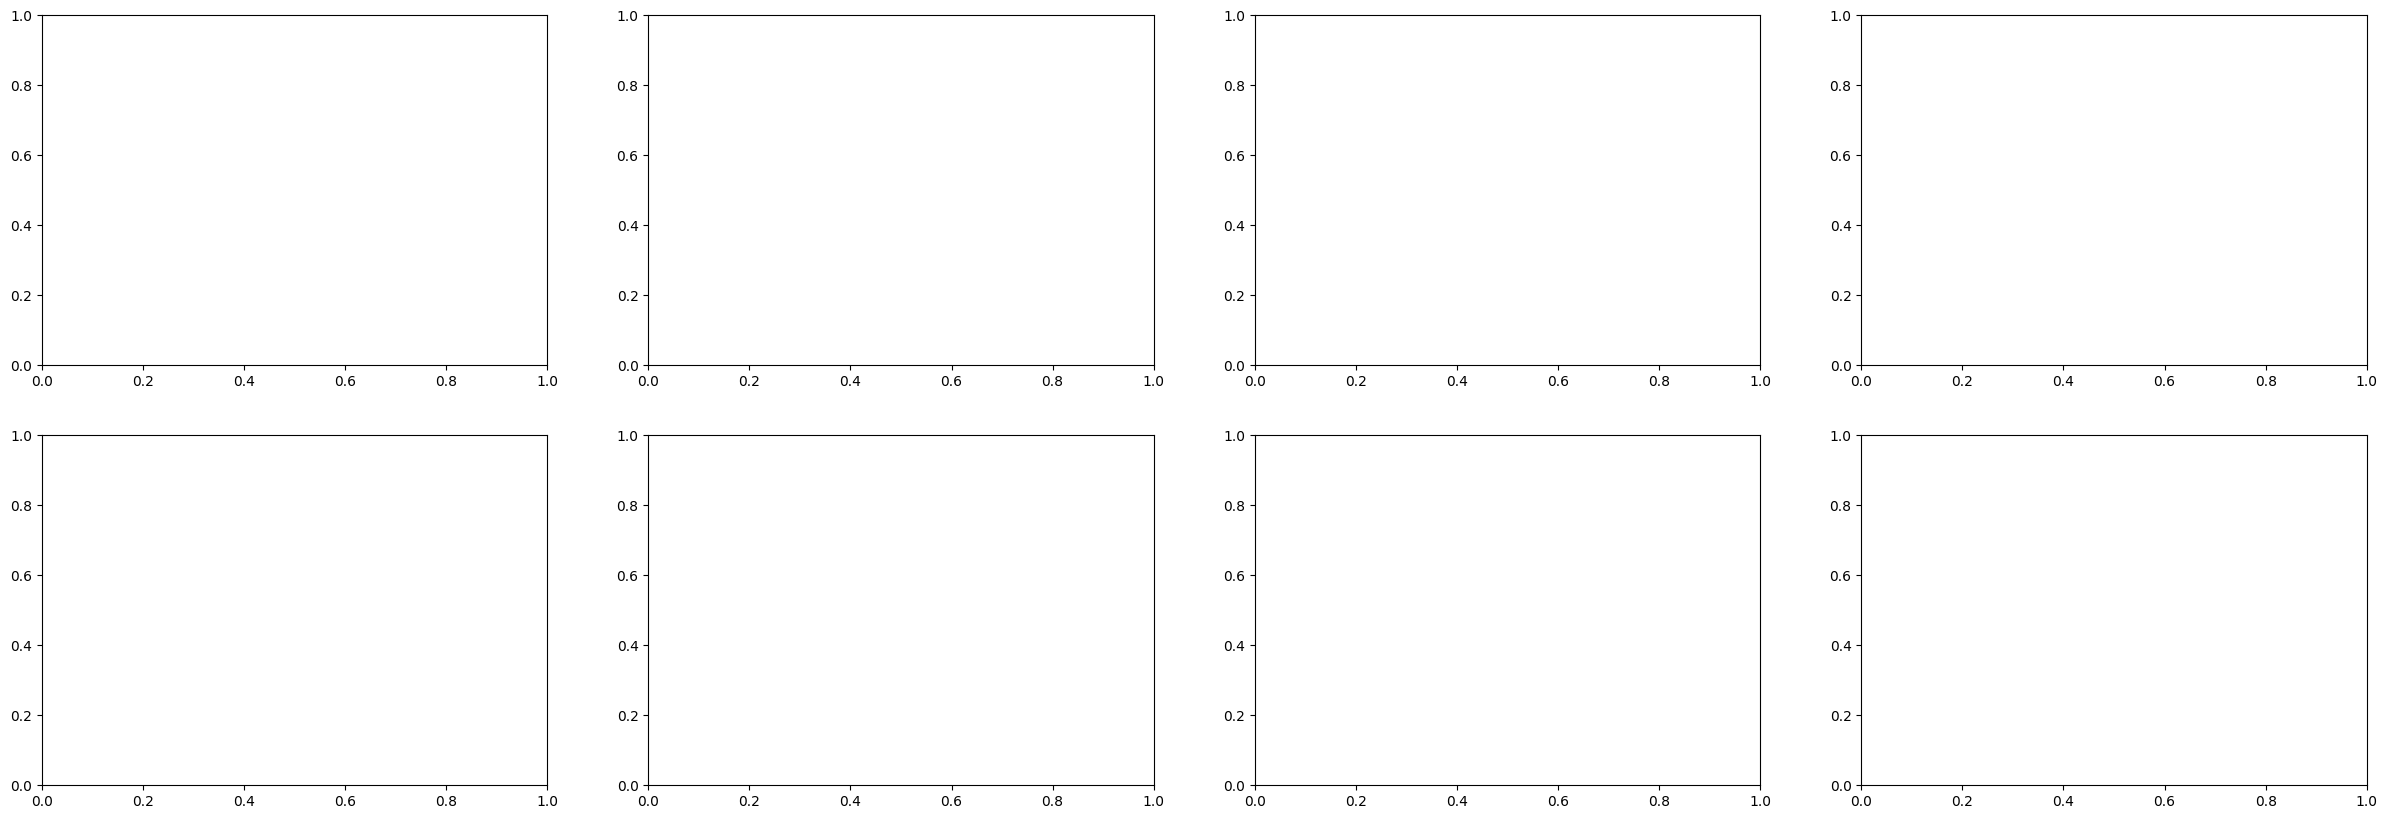

In [16]:
AGB_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB.AGB2010.plot(ax=axs[0,0], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)
AGB.AGB2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 100, add_labels=False)

In [ ]:
SD_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
SD.SD2010.plot(ax=axs[0,0], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2015.plot(ax=axs[0,1], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2016.plot(ax=axs[0,2], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2017.plot(ax=axs[0,3], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2018.plot(ax=axs[1,0], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2019.plot(ax=axs[1,1], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2020.plot(ax=axs[1,2], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2021.plot(ax=axs[1,3], cmap='jet', vmin = 0, vmax = 50, add_labels=False)

In [ ]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`